In [1]:
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
df = pd.read_csv("EV.csv")
#import data

In [2]:
df
# Load Data

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19
...,...,...,...,...,...,...,...,...,...,...
20814,January 31 2023,Rockingham,NH,Passenger,1,0,1,14,15,6.67
20815,July 31 2020,Carson City,NV,Passenger,1,0,1,10,11,9.09
20816,February 28 2022,Island,WA,Passenger,744,350,"1,094","62,257","63,351",1.73
20817,December 31 2020,San Diego,CA,Passenger,14,2,16,"2,724","2,740",0.58


In [3]:
print ("Dataset Shape:", df.shape)
# dataset rows and cols

Dataset Shape: (20819, 10)


In [4]:
df.head() # give me top 5 rows

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [5]:
# data types, class and memory alloc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [6]:
# is there any missing value, sum helps to calculate the total missing values
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

In [7]:
# Compute Q1 and Q2
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3-Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 - 1.5*IQR
print ('lower bound:', lower_bound)
print('upper_bound:', upper_bound)

#Identify Outliers
outliers = df[(df['Percent Electric Vehicles']< lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print ("Number of outliers in 'Percent Electric Vehiles':", outliers.shape[0]) 

lower bound: -3.5174999999999996
upper_bound: -0.9124999999999996
Number of outliers in 'Percent Electric Vehiles': 20819


# DATA PREPOCESSING


In [8]:
# Convert the 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Remove rows where 'Date' conversion failed
df = df[df['Date'].notnull()]
# removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]
#Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print ("Missing after fill:")
print (df[['County', 'State']].isnull().sum())

df.head() # give me top 5 rows after cleaning

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [9]:
# Cap the outliers - It keeps all the data while reducing the skew from extreme values
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound, df['Percent Electric Vehicles'])
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles'])
# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles' after capping:", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles' after capping: 0


In [10]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,2.081900e+04
mean,25.855176,21.790942,31.623093,132.845312,134.463767,-9.125000e-01
std,102.004224,92.309729,115.742017,174.033916,174.448753,2.176089e-14
min,0.000000,0.000000,0.000000,0.000000,1.000000,-9.125000e-01
25%,0.000000,0.000000,1.000000,26.000000,27.000000,-9.125000e-01
50%,1.000000,1.000000,1.000000,69.000000,70.000000,-9.125000e-01
75%,2.000000,1.000000,3.000000,167.000000,169.000000,-9.125000e-01
max,999.000000,999.000000,999.000000,999.000000,998.000000,-9.125000e-01


In [11]:
# Most EVs by County
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values (ascending = False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values (ascending = True).head(3)

print ("Top 3 Counties:\n", top_counties)
print ("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Hood River    1.0
Union         1.0
Name: Electric Vehicle (EV) Total, dtype: float64


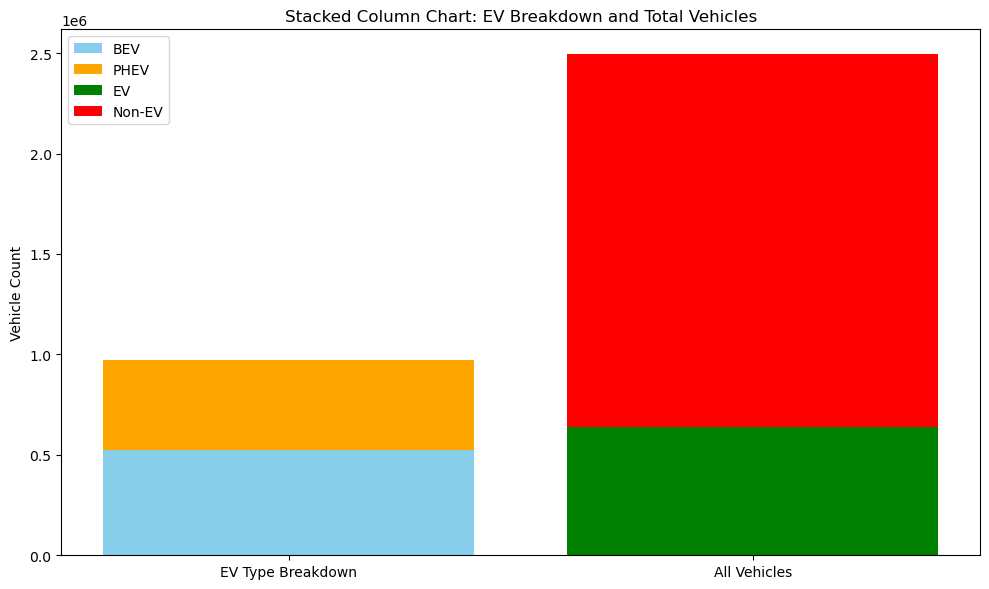

In [12]:
# Total sums for stacked column chart
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(10, 6))

# Stack EV types
ax.bar('EV Type Breakdown' , bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='green')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='red')

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()





# Feature Engnireeing

In [13]:
# Extract year, month, and date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month

In [14]:
# Enable County
Le = LabelEncoder()
df['County_encoded'] = Le.fit_transform(df['County'])

In [15]:
#sort for lag creation
df = df.sort_values(by=['County', 'Date'])

In [16]:
#Assign time index per county
df['monnths_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
for lag in range(1, 13):
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# == Rolling average (3 months, prior)  ===
df['ev_total_null_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total']\
    .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total']\
    .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total']\
    .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)





In [17]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-months rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

In [18]:
df = df.dropna().reset_index(drop=True)


In [19]:
df.to_csv('preprocessed_ev_data.csv', index=False)

In [20]:
df.head() # give me top 5 rows after feature engineering

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,ev_total_lag8,ev_total_lag9,ev_total_lag10,ev_total_lag11,ev_total_lag12,ev_total_null_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-12-31,Ada,ID,Passenger,0.0,2.0,2.0,324.0,326.0,-0.9125,...,2.0,2.0,2.0,1.0,1.0,2.0,0.0,0.0,24.0,2.0
1,2019-01-31,Ada,ID,Passenger,0.0,2.0,2.0,322.0,324.0,-0.9125,...,2.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,26.0,2.0
2,2019-02-28,Ada,ID,Passenger,0.0,2.0,2.0,320.0,322.0,-0.9125,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,28.0,2.0
3,2019-03-31,Ada,ID,Passenger,0.0,2.0,2.0,321.0,323.0,-0.9125,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,30.0,2.0
4,2019-04-30,Ada,ID,Passenger,0.0,2.0,2.0,322.0,324.0,-0.9125,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,32.0,2.0


In [21]:
# Define Feature and target
features = [
    'monnths_since_start',
    'County_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_null_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope'
]
target = 'Electric Vehicle (EV) Total'
x = df[features]
y = df[target]  

x.head()

,monnths_since_start,County_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_null_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,12,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
1,13,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
2,14,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
3,15,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
4,16,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0


In [22]:
x.shape

(10795, 9)

In [23]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2)


In [24]:
y_test.head()

8636    2.0
8637    1.0
8638    1.0
8639    1.0
8640    1.0
Name: Electric Vehicle (EV) Total, dtype: float64

In [25]:
# Define param distribution
param_dist = {
    'n_estimators': [100,150,200,250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2,4, 5, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized search 
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
# Fit the model
random_search.fit(x_train, y_train)
# Best parameters
model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}


In [26]:
y_pred = model.predict(x_test)

In [27]:
x_test.head()

,monnths_since_start,County_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_null_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
8636,95,230,2.0,1.0,1.0,1.333333,0.0,1.0,1.514286
8637,96,230,2.0,2.0,1.0,1.666667,-0.5,0.0,1.485714
8638,12,231,1.0,1.0,1.0,1.000000,0.0,0.0,1.000000
8639,13,231,1.0,1.0,1.0,1.000000,0.0,0.0,1.000000
8640,14,231,1.0,1.0,1.0,1.000000,0.0,0.0,1.000000


In [28]:
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test,
    'Predicted EV Count': y_pred
})

# Round for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df.head(10)

,Actual EV Count,Predicted EV Count
0,2.0,2.01
1,1.0,1.00
2,1.0,1.00
3,1.0,1.00
4,1.0,1.00
5,1.0,1.00
6,1.0,1.00
7,1.0,1.00
8,1.0,1.00
9,2.0,2.09


MAE: 0.02, (RMSE: 0.10), R2 Score: 1.00


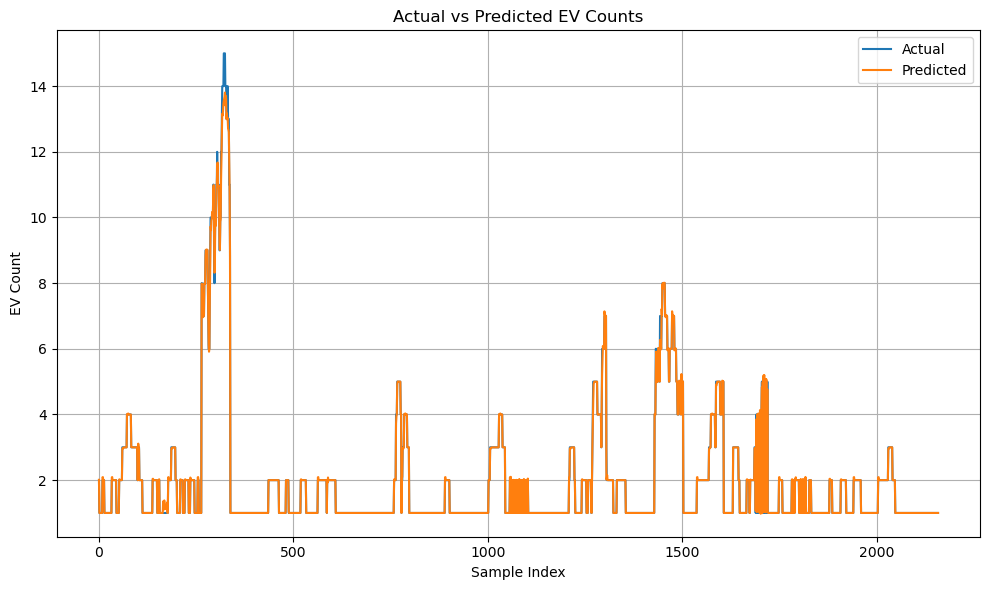

In [29]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, (RMSE: {rmse:.2f}), R2 Score: {r2Score:.2f}")
evaluate(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted EV Counts')
plt.xlabel('Sample Index')
plt.ylabel('EV Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


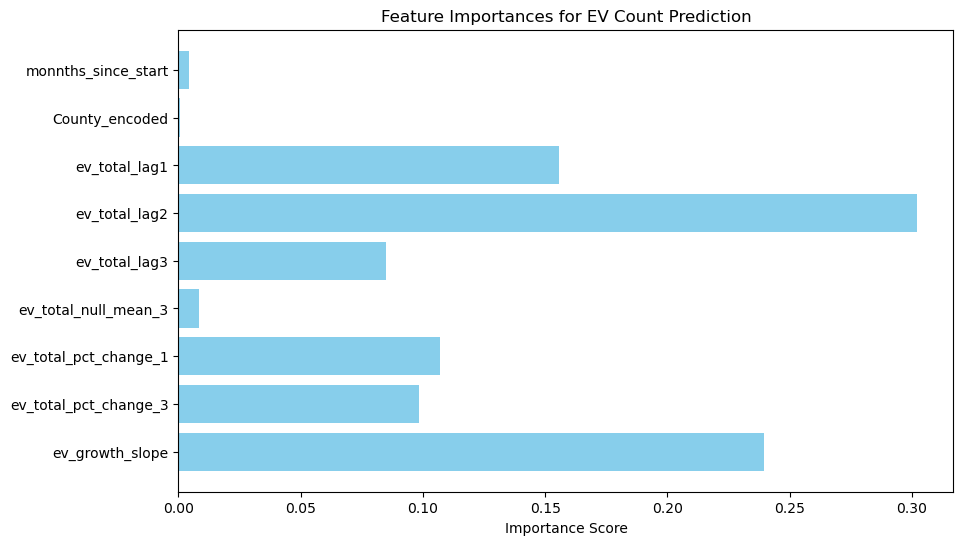

In [30]:
# Corrected the attributes name from get_feature_names_out to get_feature_names
importances = model.feature_importances_

#Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance Score')
 # Updated the title to reflect the correct feature names
plt.title('Feature Importances for EV Count Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


In [31]:
# Define features and target for the final model
featuresX = ['County', 'County_encoded']
CountyX = df[featuresX]
print("List of unique counties:")
print(df['County'].dropna().unique())
print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Autauga' 'Bartow'
 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Bexar' 'Boone' 'Boulder' 'Brevard'
 'Broward' 'Bucks' 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon'
 'Carroll' 'Carson City' 'Cascade' 'Champaign' 'Charles' 'Charleston'
 'Chesapeake' 'Clackamas' 'Clay' 'Clinton' 'Cochise' 'Collier' 'Collin'
 'Columbia' 'Contra Costa' 'Cook' 'Coryell' 'Cumberland' 'Currituck'
 'Dakota' 'Dale' 'Dallas' 'Danville' 'DeKalb' 'Denton' 'Denver'
 'Deschutes' 'District of Columbia' 'Dorchester' 'Douglas' 'DuPage'
 'Duval' 'Eagle' 'El Dorado' 'El Paso' 'Escambia' 'Essex'
 'Fairbanks North Star' 'Fairfax' 'Flathead' 'Fort Bend' 'Franklin'
 'Frederick' 'Fresno' 'Fulton' 'Galveston' 'Garfield' 'Geary' 'Goochland'
 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton' 'Hardin' 'Harford' 'Harnett'
 'Harris' 'Harrison' 'Hawaii' 'Hennepin' 'Henrico' 'Hillsborough'
 'Honolulu

In [32]:
# Set your county name
county = 'Kings'  # Replace with your county name

County 'Kings' encoded as: 130


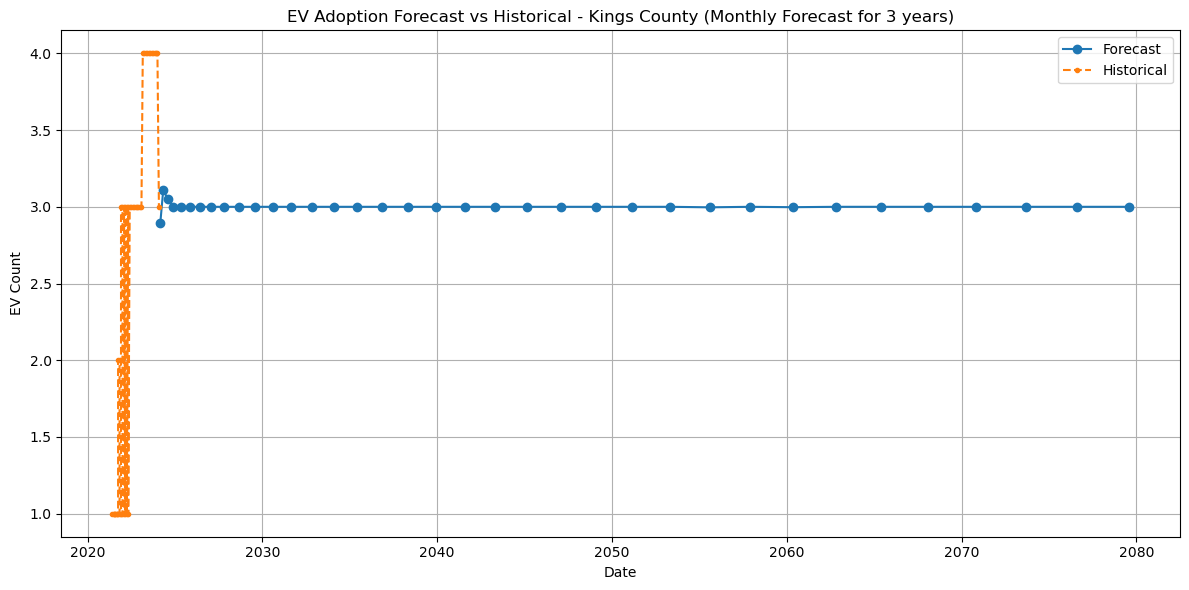

In [33]:
# Encode the county name
try:
    county_code = Le.transform([county])[0]
    print(f"County '{county}' encoded as: {county_code}")
except ValueError:
    print(f"Error: County '{county}' not found in the dataset. Please check the county name.")
    exit()

# Filter historical data
county_df = df[df['County_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"No historical data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
months_since_start = county_df['monnths_since_start'].max()

historical = county_df[['Year', 'Month', 'numeric_date', 'Electric Vehicle (EV) Total', 'monnths_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['Year', 'Month']].assign(Day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['Year'] * 100 + latest_row['Month'], format='%Y%m') + pd.DateOffset(months=i)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    if len(historical_ev) >= 3:
        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
    else:
        roll_mean = 0
        pct_change_1 = 0
        pct_change_3 = 0

    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else np.nan

    new_row = {
        'County': county,
        'County_encoded': county_code,
        'Year': y,
        'Month': m,
        'numeric_date': numeric_date,
        'monnths_since_start': months_since_start,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_null_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'cumulative_ev': cumulative_ev[-1],
        'ev_growth_slope': ev_growth_slope
    }

    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['Year'], latest_row['Month'] = y, m

# Combine data
forecast_df = pd.DataFrame(future_rows)
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'monnths_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'],
             label=source,
             marker='o' if source == 'Forecast' else '.',
             linestyle='-' if source == 'Forecast' else '--')

plt.title(f"EV Adoption Forecast vs Historical - {county} County (Monthly Forecast for 3 years)")
plt.xlabel('Date')
plt.ylabel('EV Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


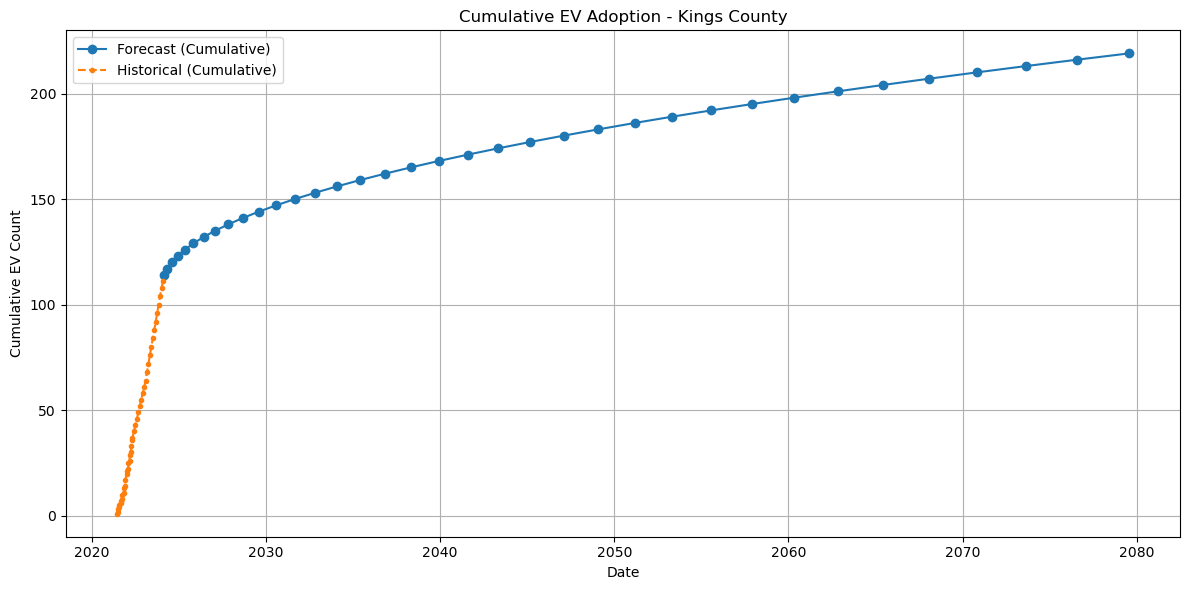

In [34]:
combined = combined.sort_values("Date")

# --- Calculate cumulative EV count ---
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# --- Plot cumulative EV adoption ---
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

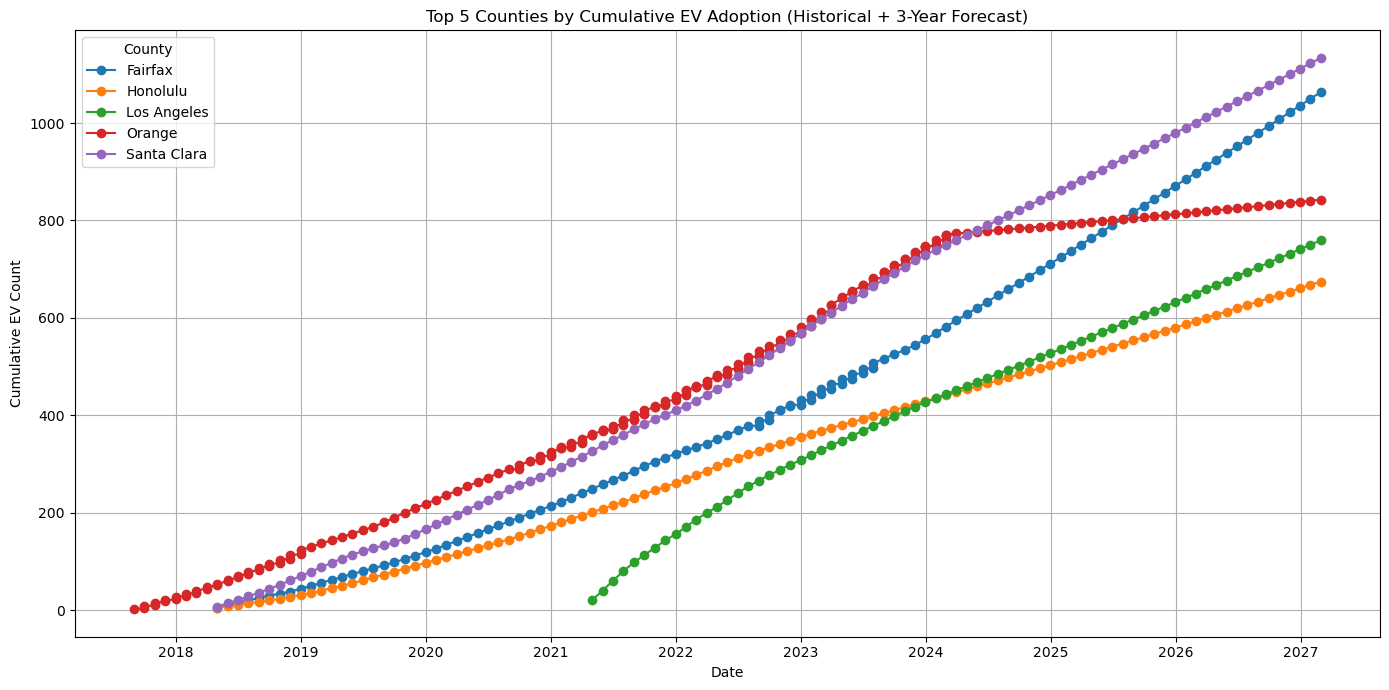

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Load your dataset (replace with your path)
# df = pd.read_csv("your_data.csv")
# For demonstration, this assumes 'df' is already loaded

# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create a numeric representation of date
df['numeric_date'] = df['Date'].dt.year * 100 + df['Date'].dt.month

# Create months_since_start column
min_date = df['Date'].min()
df['months_since_start'] = ((df['Date'].dt.year - min_date.year) * 12 +
                            (df['Date'].dt.month - min_date.month))

# Encode county labels
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

# Define features and train a basic linear regression model
df['ev_total_lag1'] = df.groupby('county_encoded')['Electric Vehicle (EV) Total'].shift(1)
df['ev_total_lag2'] = df.groupby('county_encoded')['Electric Vehicle (EV) Total'].shift(2)
df['ev_total_lag3'] = df.groupby('county_encoded')['Electric Vehicle (EV) Total'].shift(3)

df['ev_total_roll_mean_3'] = df[['ev_total_lag1', 'ev_total_lag2', 'ev_total_lag3']].mean(axis=1)
df['ev_total_pct_change_1'] = (df['ev_total_lag1'] - df['ev_total_lag2']) / df['ev_total_lag2'].replace(0, np.nan)
df['ev_total_pct_change_3'] = (df['ev_total_lag1'] - df['ev_total_lag3']) / df['ev_total_lag3'].replace(0, np.nan)

df['cumulative_ev'] = df.groupby('county_encoded')['Electric Vehicle (EV) Total'].cumsum()
df['ev_growth_slope'] = df.groupby('county_encoded')['cumulative_ev'].transform(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 6 else 0)

# Drop NaN rows used for lags
df = df.dropna()

features = ['ev_total_lag1', 'ev_total_lag2', 'ev_total_lag3',
            'ev_total_roll_mean_3', 'ev_total_pct_change_1',
            'ev_total_pct_change_3', 'ev_growth_slope']

model = LinearRegression()
model.fit(df[features], df['Electric Vehicle (EV) Total'])

# Forecast settings
forecast_horizon = 36  # 3 years
all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()
    all_combined.append(combined)

# Merge all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter for top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()


In [36]:
from sklearn.linear_model import LinearRegression
import joblib

# Train model using DataFrame (not .values)
model = LinearRegression()
model.fit(x_train, y_train)  # X_train should be a DataFrame with column names

# Save model
joblib.dump(model, 'forecasting_ev_model.pkl')


['forecasting_ev_model.pkl']

In [40]:
x_test = x_test.rename(columns={"months_since_start": "monnths_since_start"})


In [41]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [44]:
# Make predictions
# Test prediction on new or existing sample
sample = x_test.iloc[[0]]  # use one row as test
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f"\n🔍 Testing saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")



🔍 Testing saved model on 1 sample:
Actual EVs: 2.00, Predicted EVs: 2.27
